## 참고 문서

- https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html
- https://datascienceschool.net/view-notebook/3e7aadbf88ed4f0d87a76f9ddc925d69/

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import datetime
import tensorflow as tf
from tqdm.notebook import trange, tqdm

## 데이터 로드

In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]
    return data

In [3]:
train_data = read_data("./dataset/ratings_train.txt")
test_data = read_data("./dataset/ratings_test.txt")

In [4]:
print(len(train_data))
print(len(test_data))
print(train_data[0])

150000
50000
['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0']


## Tokenizing

In [5]:
from konlpy.tag import Okt

okt = Okt()

def tokenize(doc):
  tagged = okt.pos(doc, norm=True, stem=True) # norm = 정규화, step = 근어
  joined = ["/".join(t) for t in tagged]
  return joined

def tokenizeWithProgress(docs, desc):
    pairs = []
    
    for raw in tqdm(docs, desc = desc):
        tokenized = tokenize(raw[1]) # raw[1] = doc
        label = raw[2] # raw[2] = sentimental label
        paired = (tokenized, label)
        pairs.append(paired)
                     
    return pairs

In [14]:
# train_docs = tokenizeWithProgress(train_data, 'Tokenizing train dataset')
# test_docs = tokenizeWithProgress(test_data, 'Tokenizing test dataset')

In [6]:
import json
import os
from pprint import pprint

if os.path.isfile("./dataset/train_tokens.json"):
    # 저장된 파일이 있을 경우 로딩
    with open("./dataset/train_tokens.json") as f:
        train_docs = json.load(f)
    with open('./dataset/test_tokens.json') as f:
        test_docs = json.load(f)
        
else:
    # 저장된 파일이 없을 경우 컴퓨팅
    train_docs = tokenizeWithProgress(train_data, 'Tokenizing train dataset')
    test_docs = tokenizeWithProgress(test_data, 'Tokenizing test dataset')

## 태깅된 토큰들을 저장 (추후 다시 로드시)

In [23]:
with open("./dataset/train_tokens.json", "w", encoding="utf-8") as f:
    json.dump(train_docs, f, ensure_ascii=False, indent="\t")
with open("./dataset/test_tokens.json", "w", encoding="utf-8") as f:
    json.dump(test_docs, f, ensure_ascii=False, indent="\t")

In [7]:
tokens = [token for doc in train_docs for token in doc[0]] ## flatten
len(tokens)

2159921

## NLTK 라이브러리를 이용해 탐색

In [8]:
import nltk

text = nltk.Text(tokens, name = 'NMSC')
print(len(text.tokens)) # 전체 토큰
print(len(set(text.tokens))) # 중복 제외

pprint(text.vocab().most_common(20))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118),
 ('.../Punctuation', 22795),
 ('도/Josa', 20037),
 ('은/Josa', 18435),
 ('들/Suffix', 18101),
 (',/Punctuation', 17643),
 ('는/Josa', 16819),
 ('없다/Adjective', 15635),
 ('를/Josa', 15632),
 ('있다/Adjective', 12496),
 ('좋다/Adjective', 12154)]


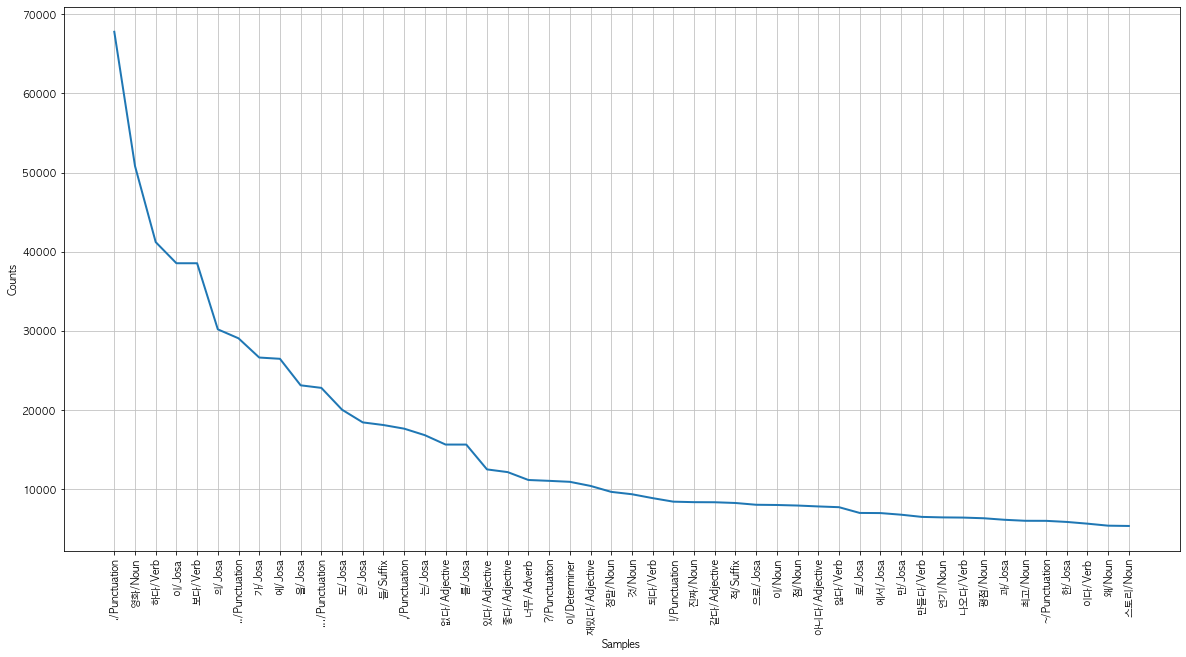

In [9]:
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc

# OSX specific
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(20,10))
text.plot(50)

## 토큰을 벡터화 하기

In [16]:
frequent_words = [pair[0] for pair in text.vocab().most_common(10000)]
frequent_words[:10]

['./Punctuation',
 '영화/Noun',
 '하다/Verb',
 '이/Josa',
 '보다/Verb',
 '의/Josa',
 '../Punctuation',
 '가/Josa',
 '에/Josa',
 '을/Josa']

In [34]:
# 토큰별로, 각 문서집합에서 Frequency 를 얻어 이를 벡터로
# token X docs

def termFrequency(doc, frequent_words):
    v = [doc.count(word) for word in frequent_words]
    return v

def termFrequencyWithProgress(docs, frequent_words, desc):
    
    vectorized = []
    for pair in tqdm(docs, desc = desc):
        doc = pair[0]
        v = [doc.count(word) for word in frequent_words]
        vectorized.append(v)

    return vectorized

In [18]:
train_x = termFrequencyWithProgress(train_docs, frequent_words, 'Vectorizing training tokens')
test_x = termFrequencyWithProgress(test_docs, frequent_words, 'Vectorizing test tokens')
train_y = [label for _, label in train_docs]
test_y = [label for _, label in test_docs]

In [21]:
import numpy as np

# converting
x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')
y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [42]:
print(x_train.shape)
print(y_train.shape)

(150000, 10000)
(150000,)


## TF 모델링

In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])
        

In [ ]:
model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

results

In [47]:
def predict(doc):
    tokens = tokenize(doc)
    term_freq = termFrequency(tokens, frequent_words)
    converted = np.expand_dims(np.asarray(term_freq).astype('float32'), axis = 0)
    score = float(model.predict(converted))
    return score

In [59]:
print(predict('좋은 영화입니다!'))
print(predict('별루인 영화입니다!'))
print(predict('노잼'))

0.9641249179840088
0.0022729597985744476
0.011636914685368538
